# Course One: Data Exploration

Expected time to complete: XX minutes

## Goal of this course
During this course we will introduce our problematic and have a first look at the data. It is one of the most important part of the modelling process: formulate our problem, understand the scope of it and more precisely the data we are going to work with.

This course is split into the following parts:
- <a href='#context'>Context</a> 
- <a href='#data_sampling'>Data sampling</a> 
- <a href='#import_data'>Import the data and have a first overview</a>
- <a href='#data_analysis'>Exploratory data analysis</a>
    - <a href='#quality_check'>Data quality check</a>
    - <a href='#scope'>Scope</a>
    - <a href='#basic_statistics'>Basic statistics</a>


<a id='context'></a>
# Context
## Background

Cultivating brand loyalty is key for the BBC to remain relevant in a data-driven world dominated by the likes of Youtube, Netflix and Facebook. We know that tens of thousands of viewers consume our content on iPlayer everyday but we still have very little understanding of what makes them come back for more. In order to keep our audience engaged, it is vital that we develop audience statistics that reflect how likely they are to continue consuming our content. These metrics will then enable us to gain greater insights into whether we are surfacing the right content to the right audience members. These activities will be vital for retaining and growing our audiences both domestically and around the world. 

## Problem Formulation
One way of measuring the engagement of a user is to count how much content they have consumed over a given period.  Engagement, measured in this way, may be affected by many different factors ranging from the kind of content they enjoy to the time of day they consume it.
 
In our current exercise, what we want to understand is how an audience member consumes content, based upon their past behaviour. More specifically, what we will do in this case is to investigate if there is a relationship between an audience member’s viewing behaviour (what and when they have watched on iPlayer) over a 14-week period and the amount of content they consumed in the subsequent two-week period.

<a id='data_sampling'></a>
# Data sampling 

## Theory
The data you use to solve your problem is called your dataset. To ensure that any inferences you make from your dataset can be generalised to “the real world” it is important to ensure that the data you choose for your dataset is indeed a good representation of the wider population it is sampled from and, in particular, free from systematic biases. Regardless of what machine-learning techniques you eventually use, if your dataset is not a good approximation of the population it is supposed to represent, you will struggle to find a satisfactory solution to your problem.

For more information on data sampling please see the Wikipedia page here:
https://en.wikipedia.org/wiki/Sampling_(statistics)  


## Our dataset
For our particular problem, we have a dataset containing __the viewing history of 10,000 iPlayer viewers__. To ensure that this is a representative sample those viewers were sampled from all over the UK and are accurate representations over all age groups, socio-economic class, race and gender. 
 
<a id='import_data'></a>
# Import the data and have a first overview

## Load the data
The first thing to do is to load the data and get a first idea what it looks like.

In [1]:
# Import all relevent libraries to analyse the data
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt

# This line makes sure that our graphs are rendered within the notebook
%matplotlib inline

# Set options to display all columns
pd.set_option("display.max_columns",None)

*pandas* is a very comprehensive library that allows us to manipulate datasets and perform data analysis. Among others it has a great datetime parsing function which will make handling datetimes later much easier!

Make sure to have your dataset in the same folder as your notebook. Or specify its path `'path/to/data/iplayer_data_sample_janapr2017.csv'`.

In [2]:
# Load the data into a pandas dataframe
# Display the size of the dataset and first couple of rows to see what it looks like
data=pd.read_csv('iplayer_data_sample_janapr2017.csv', parse_dates=['start_date_time'])
print(data.shape)
print(data.head())

(490852, 8)
  user_id program_id series_id          genre programme_duration  \
0  cd2006     f6d3d8    a282ca        Factual           00:00:21   
1  cd2006     b8fbf2    e0480e         Comedy           00:01:51   
2  cd2006     e2f113    933a1b        Factual           00:00:30   
3  cd2006     0e0916    b68e79  Entertainment           00:01:22   
4  cd2006     ca03b9    5d0813          Sport           00:01:37   

      streaming_id         start_date_time  time_viewed  
0  1486911129420_1 2017-02-12 14:51:24.544      20920.0  
1  1484864257965_1 2017-01-19 22:17:04.648     111285.0  
2  1487099603980_1 2017-02-14 19:12:36.667      29945.0  
3  1484773546557_1 2017-01-18 21:05:11.466      82620.0  
4  1486911176609_1 2017-02-12 14:52:08.965      97444.0  


This output gives us a broad sense of what our data look likes. We can start creating additional derived columns that we think could explain why and how much people will watch on iPlayer. This step is called __feature engineering__. 

## Feature engineering
Feature engineering is the process of identifying the input variables (_time of the day, content genre_ etc.) that will be used by your model to predict the output variable (_number of minutes watched_). Feature engineering is _very_ important as the performance of your model is directly dependent upon the features you choose as input. Statistical models are essentially just pattern detectors. Different types of models have strengths and weaknesses in specific situations but they can only find structure in your data if the information exists in your features, in the first place.

In most situations the process of feature engineering is an iterative one. Finding the best subset of explanatory variables is not straightforward and we will come back later on this. In the meantime, we will enhance the data by calculating some additional features that we think can help predict the viewing-time of iPlayer users. 

Our hypothesis is that the more you interact with iPlayer, the more likely you are to return. So the additional data columns are aimed at understanding __the breadth of the user's interactions with us__.

In [3]:
# Enhance the data with a few additional columns
# Here we create some functions that we will apply to our dataset columns afterwards

# Get the weekday
def get_weekday(formated_time):
    return 'weekday_' + str(formated_time.weekday())

# Get the two-week number. We will forecast the minutes watched in the last two weeks
# Python3 rounds 0.5 up and down depending on the integer so we can't use round function
def get_twoweeknumber(formated_time):
    return math.floor(formated_time.isocalendar()[1]/2.0)

# Get the time of day
def get_timeofday(formated_time):
    hour=formated_time.hour
    if hour in range(5,13):
        return 'Morning'
    elif hour in range(13,18):
        return 'Afternoon'
    elif hour in range(18,23):
        return 'Evening'
    else:
        return 'Night'

# Parse the programme duration 
# and turn it into minutes so that we can compute the percentage of time watched
def parse_programme_duration(unformated_time):
    try:
        timeparts=unformated_time.split(':')
        return int(timeparts[0])*60.0+int(timeparts[1])+int(timeparts[2])/60.0
    except:
        return

In [4]:
# Apply the functions to the dataframe
data['weekday']=data['start_date_time'].apply(get_weekday)
data['time_of_day']=data['start_date_time'].apply(get_timeofday)
data['programme_duration_mins']=data['programme_duration'].apply(parse_programme_duration)
data['twoweek']=data['start_date_time'].apply(get_twoweeknumber)

# Convert time viewed and length of programme into minutes
data['min_watched']=data['time_viewed']/(60000.0)

data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067


<a id='data_analysis'></a>
# Exploratory data analysis

Once we have our dataset, enhanced with some additional features we can start its exploration. First of all, we need to check the quality of the data we are working with. Most data sources are very "noisy": often data is missing for some observations or data can also be wrong. It is therefore crucial to spend some time cleaning the data to avoid a "garbage in, garbage out" problem. Cleaning involves both __infer missing values__ and identify __outliers__ (statistically improbable values). When dealing with missing or unusual values, keep always in mind the “business" and context of your analysis. 

Generally the investigation and enrichment of data is quite a cyclical process. As you investigate the data you have new ideas on how to fix and enrich it and you will then again check whether you have any missing or clearly wrong values in your dataset. 

Exploratory data analysis allows us as well to get a “feel” for our dataset and provides useful insights regarding the best techniques or models to use later on in the modelling stage. Data exploration can involve many different techniques and approaches but will invariably include generating __descriptive statistics__ and __visualising distributions__. Summarising our data in this way is not only useful for checking the assumptions that many models hold about our data but can also be useful to perform “sanity checks” when evaluating the output of the more complex models we use later on.

<a id='quality_check'></a>
## Data quality check
### Missing values

In [5]:
# Check how many missing and unique values there are per column
features=data.columns.values
for feature in features:
    print(feature,'- Missing:', 
          sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259532
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259532


Sometimes we can improve our model by not dropping rows with missing data, but instead trying to impute what the missing values should be.  _Scikit_ has a whole set of functions for this (such as imputing the median or a fixed number), but we will create our own functions in this case because it makes it more clear what we are doing. 

It is important to remember that by imputing data into empty fields we are almost always __making assumptions__ about the structure of the data. These assumptions can be more or less valid. For example, to impute genre, we may choose series ID or we may choose broadcast hour. If we impute from series ID we are making the assumption that all programs within a specific series will have the same genre. Alternatively, if we impute from broadcast hour we are assuming that all shows broadcast at a specific hour of the day are the same genre. You must judge for yourself whether these assumptions are valid or not. 
 
Since the field `genre` has only a small number of possible values but quite a large number of missing values, we will start by imputing it to reduce the amount of missing data. After that the most useful column to impute is probably `programme_duration`, again because it is quite easy to impute and will remove a fair amount of missing data. 

We could also think about imputing `series_id` as well if we wanted to get really clever at a later stage (maybe the same programme sometimes has a `series_id` and sometimes it doesn't). 

For the other missing variables imputation probably makes little sense at this stage. 

Again, usually we would cycle through the whole process of imputing data > building features > building/training models > evaluating models multiple times. By having a clear success metric, it makes it much easier for us to see whether any of the additional complexity delivers value.

#### Genre

Let's see first whether we can guess the genre based on the id of the piece of content.

In [6]:
# First create a data frame that maps each piece of content with its genre
series_mapping=pd.pivot_table(data,values='streaming_id',
                              index=['series_id'],
                              columns=['genre'],
                              aggfunc=len).idxmax(axis=1)
series_mapping=pd.DataFrame(series_mapping).reset_index().rename(columns={0:'enriched_genre'})
series_mapping.head()

,series_id,enriched_genre
0,001b96,Factual
1,00389f,Factual
2,00400b,Children's
3,00434d,Factual
4,0079b7,Factual


In [7]:
# Let's merge in the genre back into the data
data=pd.merge(data,series_mapping,how='left',on='series_id')
data[data['genre'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre
134,3387a6,47f8c1,c9cc1a,NaN,00:00:00,1485900618555_1,2017-01-31 22:10:20.049,3584.0,weekday_1,Evening,0.0,2,0.059733,Factual
140,3387a6,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:10:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,NaN
141,3387a6,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:01:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,NaN
142,3387a6,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 21:38:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,NaN
143,3387a6,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 07:53:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,NaN


In [8]:
# Check how many missing and unique values for this column
features=['genre','enriched_genre']
for feature in features:
    print(feature,'- Missing:',sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

genre - Missing: 67719 - Unique: 12
enriched_genre - Missing: 43829 - Unique: 12


So while this has made things better (compare `genre` to `enriched_genre`), we are still missing the genre for a lot of different rows of data.

Let's try to infer the genre based on seasonality patterns.

In [9]:
# What genre is the most popular at which time of day
genre_by_time=pd.pivot_table(data,values='streaming_id',
                             index=['time_of_day'],
                             columns=['enriched_genre'],
                             aggfunc=len).idxmax(axis=1)
genre_by_time=pd.DataFrame(genre_by_time).reset_index().rename(columns={0:'enriched_genre'})
genre_by_time

,time_of_day,enriched_genre
0,Afternoon,Factual
1,Evening,Factual
2,Morning,Factual
3,Night,Factual


Maybe the time of the day isn't granular enough. Let's consider the hour the content is displayed.

In [10]:
# What genre is the most popular at which hour of day
# Rmk: we first need to build this new feature
data['hour']=data.start_date_time.apply(lambda x:x.hour)
genre_by_hour=pd.pivot_table(data,values='streaming_id',
                             index=['hour'],
                             columns=['enriched_genre'],
                             aggfunc=len).idxmax(axis=1)
genre_by_hour=pd.DataFrame(genre_by_hour).reset_index().rename(columns={0:'enriched_genre_hour'})
genre_by_hour

,hour,enriched_genre_hour
0,0,Factual
1,1,Factual
2,2,Factual
3,3,Factual
4,4,Factual
5,5,News
6,6,News
7,7,Factual
8,8,Factual
9,9,Factual


With this granularity we can get the news pattern in the morning and the movies at night.

In [11]:
# Let's merge in the genre back into the data
data=pd.merge(data,genre_by_hour,how='left',on='hour')
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,14,Factual
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,14,Factual


In [12]:
# Function that imputes a genre based on the series id or the time of day if data is missing
def impute_genre(row):
    if isinstance(row['genre'],str):
        return row['genre']
    elif isinstance(row['enriched_genre'],str):
        return row['enriched_genre']
    else:
        return row['enriched_genre_hour']

In [13]:
# Apply the function to the dataframe
data['enriched_genre']=data.apply(impute_genre, axis=1)

In [14]:
# Check how many missing and unique values for this column
features=['genre','enriched_genre']
for feature in features:
    print(feature,'- Missing:',sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

genre - Missing: 67719 - Unique: 12
enriched_genre - Missing: 0 - Unique: 11


#### Programme duration

Now we can impute the length of a programme as well. The assumption we are making here is that the length of programmes of the same genre should be similar. 

Since our data is unlikely to be normally distributed we will use the median instead of the mean as our "average" programme duration.

In [15]:
# Check whether this has worked
data[data['genre'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour
134,3387a6,47f8c1,c9cc1a,NaN,00:00:00,1485900618555_1,2017-01-31 22:10:20.049,3584.0,weekday_1,Evening,0.0,2,0.059733,Factual,22,Drama
140,3387a6,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:10:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,Drama,21,Drama
141,3387a6,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:01:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,Factual,16,Factual
142,3387a6,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 21:38:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,Drama,21,Drama
143,3387a6,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 07:53:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,Factual,7,Factual


In [16]:
# Check the average length of a programme based on genre 
# Rmk: we rename the columns for merging afterwards
length_by_genre=data.groupby('genre')['programme_duration_mins'].median()
length_by_genre=pd.DataFrame(length_by_genre).reset_index().rename(columns={'programme_duration_mins':
                                                            'enriched_duration_mins',
                                                            'genre':'enriched_genre'})
length_by_genre

,enriched_genre,enriched_duration_mins
0,Children's,15.0
1,Comedy,28.0
2,Drama,45.0
3,Entertainment,30.0
4,Factual,45.0
5,Learning,10.0
6,Music,60.0
7,News,30.0
8,Religion & Ethics,60.0
9,Sport,80.0


In [17]:
# Let's merge in the duration back into the data
data=pd.merge(data,length_by_genre,how='left',on='enriched_genre')
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,14,Factual,45.0
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama,28.0
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual,45.0
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama,30.0
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,14,Factual,80.0


In [18]:
# Function that imputes a duration based on the (enriched) genre
def impute_duration(row):
    if row['programme_duration_mins']>0:
        return row['programme_duration_mins']
    else:
        return row['enriched_duration_mins']

In [19]:
# Apply the function to the dataframe
data['enriched_duration_mins'] = data.apply(impute_duration, axis=1)

In [20]:
# Check whether this has worked
data[data['programme_duration_mins'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins
140,3387a6,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:10:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,Drama,21,Drama,45.0
141,3387a6,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:01:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,Factual,16,Factual,45.0
142,3387a6,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 21:38:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,Drama,21,Drama,45.0
143,3387a6,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 07:53:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,Factual,7,Factual,45.0
144,3387a6,NaN,NaN,NaN,NaN,1489258896796_3,2017-03-11 19:01:39.890,3545.0,weekday_5,Evening,NaN,5,0.059083,Factual,19,Factual,45.0


In [21]:
# Check how many missing and unique values for this column
features=['programme_duration_mins','enriched_duration_mins']
for feature in features:
    print(feature,'- Missing:',sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

programme_duration_mins - Missing: 33698 - Unique: 891
enriched_duration_mins - Missing: 0 - Unique: 889


### Outliers
Let's now have a look at the unusual values.

#### Watched time

In [22]:
data.time_viewed.describe()

count    4.889520e+05
mean     8.565867e+05
std      3.491022e+06
min     -3.563513e+06
25%      3.935000e+03
50%      8.194150e+04
75%      9.219698e+05
max      8.515021e+08
Name: time_viewed, dtype: float64

There are some outliers here: negative values for the watched time. We will consider that these values are errors and take the absolute value to make them positive.

In [23]:
# Assume that is error and make positive
data['time_viewed']=abs(data['time_viewed'])

#### Number of minutes watched

We built `min_watched` based on `time_viewed`. We need thus to recreate this variable as we underlined outliers for this field.

In [24]:
data['min_watched']=data['time_viewed']/(60000.0)
data.min_watched.describe()

count    488952.000000
mean         14.276694
std          58.183645
min           0.000000
25%           0.065583
50%           1.365700
75%          15.366200
max       14191.701283
Name: min_watched, dtype: float64

#### Percentage completion of a programme

Now that we have an enriched duration (no more missing values) and a watched time field corrected from its outliers, we can calculate how much (in %) of the programme the viewer watched.

In [25]:
# Percentage of content watched by the user
data['percentage_watched']=(data['min_watched']/data['enriched_duration_mins'])
data.percentage_watched.describe()

count    488952.000000
mean          1.055101
std          17.764685
min           0.000000
25%           0.004066
50%           0.139502
75%           0.806020
max        4971.469250
Name: percentage_watched, dtype: float64

Here again there are wrong values (percentage >1) that we need to correct. We will set the maximum for this field to 1. 

In [26]:
# Clean up the percentage field from when the number is more than 100%
def clean_perc(number):
    return min(number,1)

In [27]:
# Clean up percentaged watched from anything bigger than 100%
data['percentage_watched']=data['percentage_watched'].apply(clean_perc)

Let's have a look at our data after this imputation step.

In [28]:
# Check how many missing and unique values there are per column
features=data.columns.values
for feature in features:
    print(feature,'- Missing:', 
          sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259529
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259529
enriched_genre - Missing: 0 - Unique: 11
hour - Missing: 0 - Unique: 24
enriched_genre_hour - Missing: 0 - Unique: 3
enriched_duration_mins - Missing: 0 - Unique: 889
percentage_watched - Missing: 1900 - Unique: 298006


In [29]:
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins,percentage_watched
0,cd2006,f6d3d8,a282ca,Factual,00:00:21,1486911129420_1,2017-02-12 14:51:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,14,Factual,0.350000,0.996190
1,cd2006,b8fbf2,e0480e,Comedy,00:01:51,1484864257965_1,2017-01-19 22:17:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama,1.850000,1.000000
2,cd2006,e2f113,933a1b,Factual,00:00:30,1487099603980_1,2017-02-14 19:12:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual,0.500000,0.998167
3,cd2006,0e0916,b68e79,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:05:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama,1.366667,1.000000
4,cd2006,ca03b9,5d0813,Sport,00:01:37,1486911176609_1,2017-02-12 14:52:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,14,Factual,1.616667,1.000000


<a id='scope'></a>
## Scope

We will work on a week time basis for the modeling. Python weeks start on Monday and since the 1st of January was a Sunday we will ignore this day for the rest of the analysis.

In [30]:
# Drop the 1st of January - incomplete week
data=data[data['start_date_time']>'2017-01-02']

<a id='basic_statistics'></a>
## Basic statistics

### Distributions

Now that our data looks quite reasonable, let's plot what we have to get a better visual understanding of our feature  distributions. This helps us to perform some quick "sanity" checks and make sure the data makes sense.

#### Programme duration

For this __histogram__, on the x-axis we have the programme length in minutes and on the y-axis we have the number of shows for that duration that we _observe_ in our data. Note that here a given show can be counted more than once as we are considering the raw dataset of all the observations and not a content id granularity.

The plot shows what's called a "long-tailed" distribution. It indicates that the vast majority of watched shows last less than a minute. These are likely to be short clips. We also see spikes around 30 and 60 minutes, which make sense as when considering the length of most shows broadcast on BBC. Interestingly, in this dataset, there are more watched shows that last an hour than last half an hour.

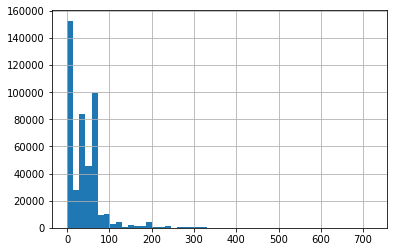

In [31]:
# Check the distribution of our numerical values
data['programme_duration_mins'].hist(bins=50)

#### Number of minutes watched

We should expect that the distribution of the number of minutes watched should loosely reflect the one of the programme duration. Indeed, from the plot below we can see a large spike at 1 minute and then two smaller spikes around the 30 and 60 minute marks. However, there are also differences between the two distributions. Compared to the 30 and 60 minutes spikes, the 1-minute spike is much larger for the number of minutes watched than than for the programme duration.

One hypothesis for why this might be is that, more often than not, people do not finish watching what they started. The 1-minute column below is not only made up of viewings of 1-minute shows, but in addition, it represents all the times that people started watching something and quickly switched off or over to something else.

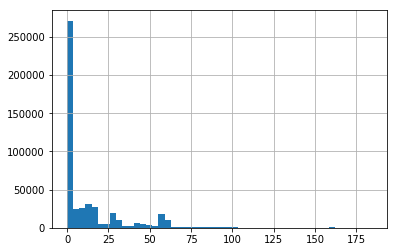

In [32]:
# Check the distribution for length watches (under 200 mins to be able to see more)
data[data['min_watched']<200]['min_watched'].hist(bins=50)

#### Percentage completion of a programme

We can test our hypothesis by having a look at the distribution that shows how much the user watched during their viewing. We can see from the plot displayed below that, indeed, about 32% (~16k/total ~50k) of the total views are represented in the very first bar (there are 50 bars so each bar represents 2% of the show). This represents evidence that it is consistent with out hypothesis from the previous section. 

The plot also indicates that only about 16% of the views reached the very end of the show. However, at this point we have to remember that all of the outliers (i.e. all of those values over 1 - or 100%) were rounded down to 1. This means that the final column will be artificially inflated, although the overall pattern is not likely to be too different.

The remaining 52% stopped watching somewhere in between. We can see that the likelihood of a viewer stopping drops significantly after the first 2% of the show (first bar). Then, the likelihood of a viewer stopping at any given time continues to drop until around the 80% completion mark, at which point it it begins to sharply rise again.

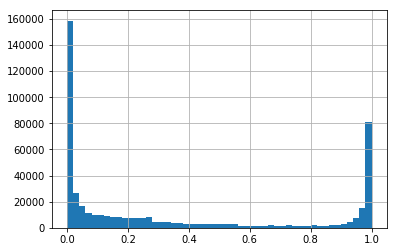

In [33]:
# Check the distribution of the completion rate
data['percentage_watched'].hist(bins=50)

#### Two week groups

Next, let's have a look at the amount of data in our dataset over time.  The __bar plot__ of the value counts below show that all 2-week periods contain between 5.5k and 6.5k of views, apart from group 0, which contains just over 3k of views.

Generally, if we assume equivalence between groups, we hope to have similar counts of data within those groups. If one group unexpectedly has a significantly different amount of data, this might be an indication of something strange happening during the sampling process. This is not necessarily the case here but it is worth considering why it does so.

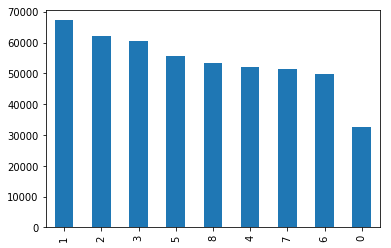

In [34]:
# Check whether we have more or less the same amount of data for each two week period
data['twoweek'].value_counts().plot(kind='bar')

#### Genre and enriched genre

To see what type of shows are the most popular with our viewers, we can plot the distribution of genres in our dataset. This gives us an idea of what kind of content people are consuming the most.

Here, it looks like "Factual" and "Drama" shows are consumed at a much higher rate than any of the other genres. It is worth noting, however, that does not necessarily mean that "Factual" and "Drama" shows are the more popular than "Entertainment" shows. An alternative and equally valid interpretation of the data here is that there are more "Factual" and "Drama" shows on iPlayer than any other genre. If this were the case, there would always likely be more views in these categories, regardless of popularity. Can you think of a way to assess the popularity of a genre, independently of the volume of content? 

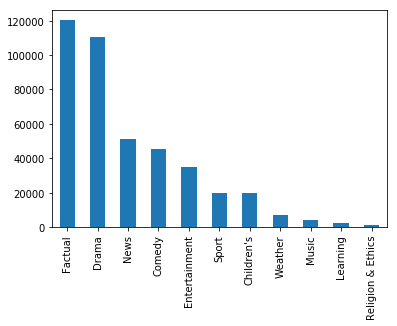

In [35]:
# Check distribution of categorical values
data['genre'].value_counts().plot(kind='bar')

We can learn more about our imputation process by comparing the distribution of genres before and after imputation. Below we plot the genres after imputation.

Ideally, the shape of the distribution of genres, before and after imputation, will not change. If it does not change, this is an indication that imputation process has not significantly changed the original dataset and therefore, you have not introduced any bias (although the original dataset may still contain biases). If the distribution has changed after imputation (here it looks like "Factual" has become more viewed after imputation), further consideration is needed.

A change in the distribution is an indication that the missing data you have imputed was not uniformly distributed throughout the dataset (e.g. perhaps the "Factual" producers rarely tag their content with a genre) or you imputation process is dodgy and has introduced some systematic bias. As the idea that a certain type of content might be less well tagged than another is a plausible one, we needn't worry too much here for now.

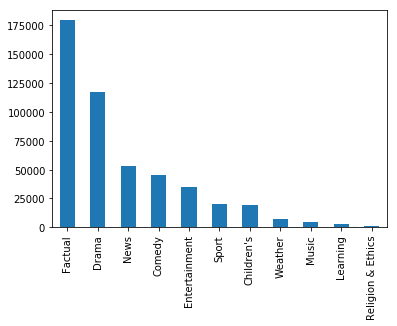

In [36]:
# How does this differ from the distribution of the enriched genre?
data['enriched_genre'].value_counts().plot(kind='bar')

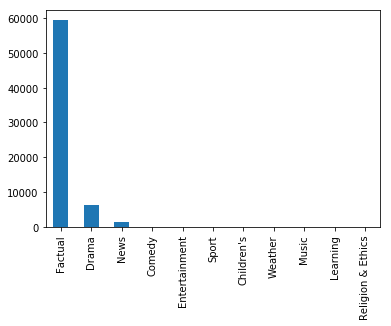

In [37]:
# Plot the difference between the genre and enriched genre.
diff = data['enriched_genre'].value_counts() - data['genre'].value_counts() 
diff.plot(kind='bar')

#### Time of the day

As a further sanity check we will look at what times of the day people are consuming the content. And as one might expect, the most views are registered in the evening, then the afternoon, while the least views are recorded during the morning and night. 

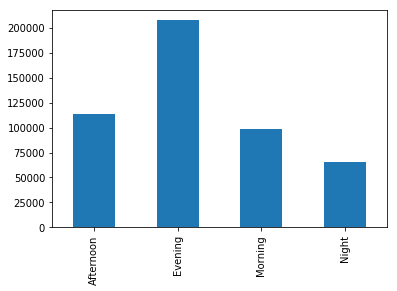

In [38]:
# When do people mostly watch (distribution over time of day)?
data['time_of_day'].value_counts().sort_index().plot(kind='bar')

By comparing the distribution of the programme views across the day with a distribution of the number of minutes watched consumed across the day (below), we can get some insight into the typical length of a shows at different times in the day.

The observation that in the number of minutes viewed distribution, "Afternoon" and "Morning" are more equal than in the previous plot may indicate that the average show in the morning is longer than the average show in the afternoon. As extended breakfast TV shows often dominate the early morning schedule and "daytime TV" shows are more discretised, this interpretation is plausible. 

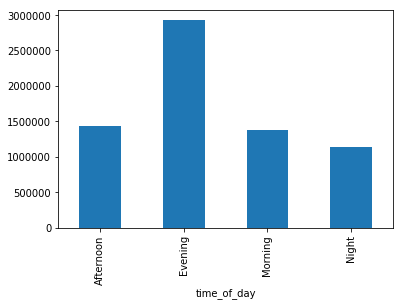

In [39]:
data.groupby(['time_of_day'])['min_watched'].sum().plot(kind='bar')

#### Time of the week

Next we shall observe how viewing trends vary on a less granular timescale: the days of the week. What we find is that viewing figures decline steadily from Monday until Friday, improve on Saturday, then reach their peak every Sunday.

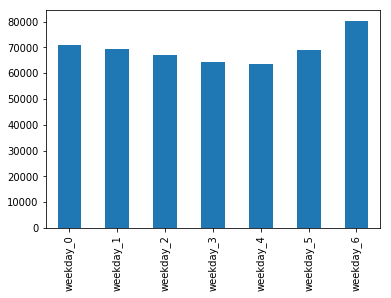

In [40]:
# Distribution over the weekday (weekday_0 is Monday)
data['weekday'].value_counts().sort_index().plot(kind='bar')

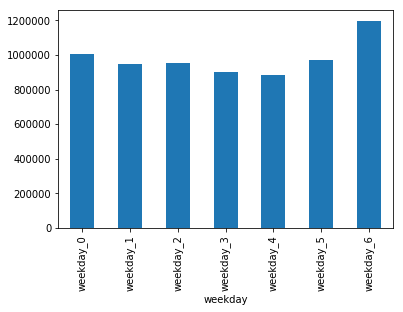

In [41]:
data.groupby(['weekday'])['min_watched'].sum().plot(kind='bar')

By looking at the equivalent plot for the number of minutes consumed (above) we see a very similar pattern to total views, providing little evidence that the average length of a show varies from day to day.

One caveat to this statement is the bump of minutes consumed we see on Wednesday. This is an indication that on Wednesdays people are watching more minutes than would be expected from the number of views. This could be a consequence of longer shows being broadcast on a Wednesday or an alternative hypothesis is that people choose to watch longer shows on a Wednesday, perhaps due to fatigue. Of course, these two hypotheses are not mutually exclusive. 

#### Time of the week and time of the day

Finally, let's have a look to see if the daytime distributions change of the course of the week.

From looking at the blue plots below it appears that there are very few differences to observe. However, by looking at the difference between the average views per day and views from a specific day (the "difference from average" plots), we can get further insight upon why variation in views exist across days.

For example, if we look at this plot for weekday 0 (Monday), we can see that Monday's are distinct from the average day in that there are more views in the evening and afternoon, less views in the morning and about the same at night. If we look at the weekend, we can see that Saturday has slightly more views in the morning, afternoon and night views but quite a lot less evening views than the average day of the week (probably due to people going out on a Saturday night). On Sunday, we see many more views overall than the average day, but this is  especially the case in the morning. As these observations seem to make sense, we have a much greater confidence in our dataset than we did before.


*********** 

weekday_0



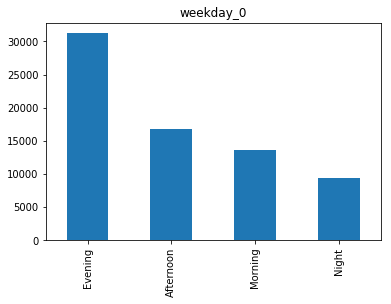

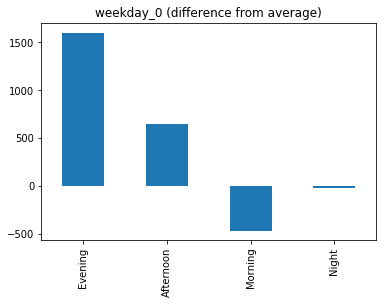


*********** 

weekday_1



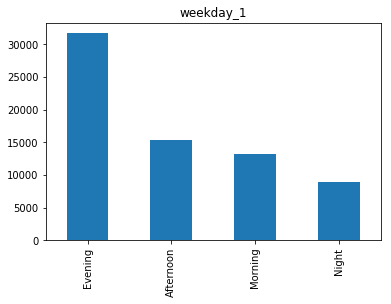

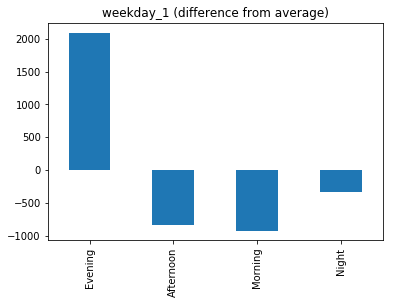


*********** 

weekday_2



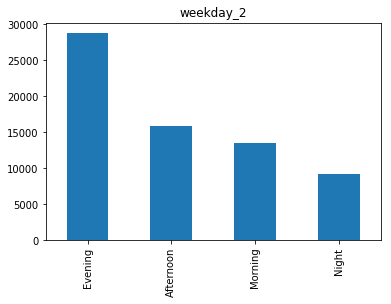

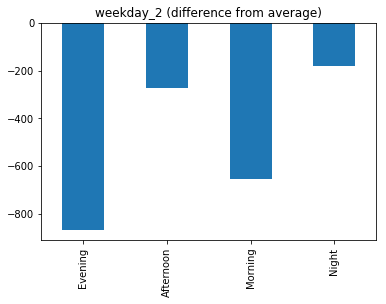


*********** 

weekday_3



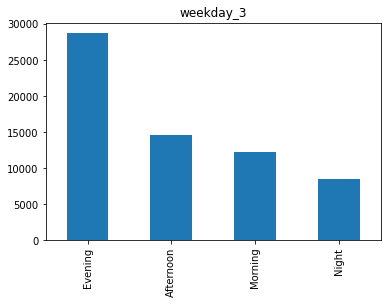

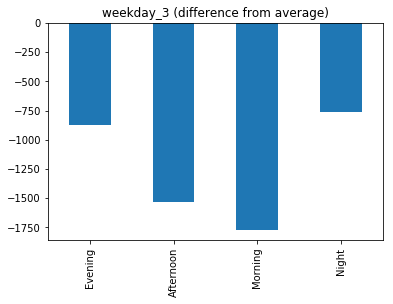


*********** 

weekday_4



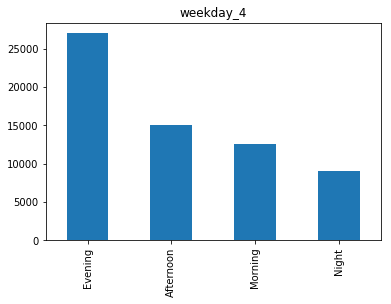

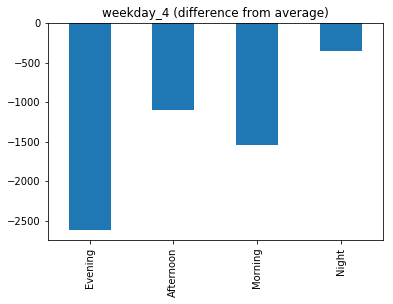


*********** 

weekday_5



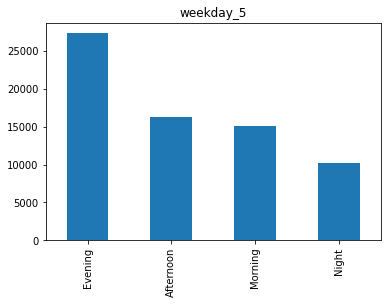

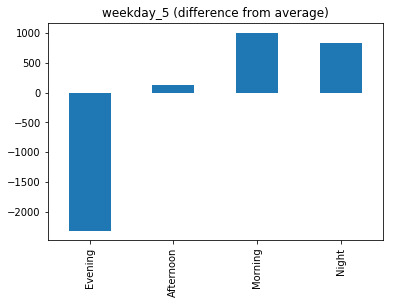


*********** 

weekday_6



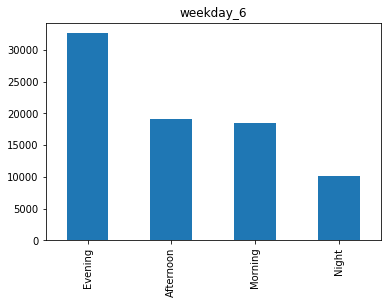

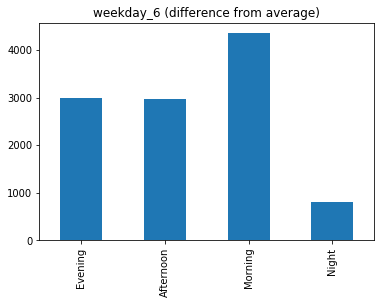

In [42]:
# Let's look at whether people watch at different times across different days
averageCounts  = data['time_of_day'].value_counts() / 7
for day in sorted(set(data['weekday'])):   
    print('\n*********** \n')
    print(day+'\n')
    
    data[data['weekday']==day]['time_of_day'].value_counts().plot(kind='bar')
    plt.title(day)
    plt.show()
    
    diff = data[data['weekday']==day]['time_of_day'].value_counts() - averageCounts
    diff.plot(kind='bar')
    plt.title(day+" (difference from average)")
    plt.show()

Comparing distributions and frequency counts in this way is helpful for checking whether our data is sensible but it is important to remember that these are not formal analyses. If we wanted more certain information about the difference between viewing behaviour on different days, we should use statistical tests (e.g chi-squared) which calculate not only the difference between a measure but also the significance of that difference.

### Engagement

Bearing in mind that we want to forecast engagement, and at a user level, we should do some descriptive statistics and get orders of magnitude in our data.

It is first useful business insights, but can also be used in the forecasting part to make sure our results make sense. If we forecast an average number of minutes watched in the following two weeks much higher or lower than the one observed in past data, we can raise doubts on our modeling techniques. 

#### Number of users

In [43]:
# Get the number of unique users in the dataset
print('Number of users: '+
      str(len(data.user_id.unique())))

Number of users: 9792


#### Number of observations per user on a two-weeks basis

The `groupby` _pandas_ function is really convenient to aggregate data according to a given field and given metrics. For more details: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html 

In [44]:
# We first need to aggregate the number of observations per user per twoweek
# Describe gives us some basic statistics on this new field
data.groupby(['user_id','twoweek']).size().describe()

count    39823.000000
mean        12.169450
std         20.696486
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        496.000000
dtype: float64

On average we have 12 observations per user per `twoweek`. Let's plot the historgram to get a better idea of the distribution.

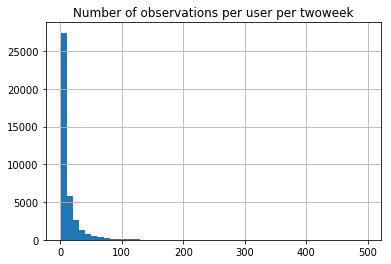

In [45]:
data.groupby(['user_id','twoweek']).size().hist(bins=50)
plt.title('Number of observations per user per twoweek')
plt.show()

We can thus see __various levels of engagement__ within the users on a two-weeks basis. Let's have a look at the minutes watched as well.

#### Number of minutes watched per user on a two-weeks basis

In [46]:
# We first need to aggregate the number of observations per user per twoweek
# Describe gives us some basic statistics on this new field
data.groupby(['user_id','twoweek'])['min_watched'].sum().describe()

count    39701.000000
mean       172.925041
std        410.119518
min          0.000283
25%          8.230650
50%         55.950167
75%        170.692000
max      14205.462117
Name: min_watched, dtype: float64

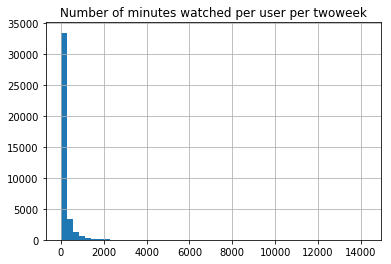

In [47]:
# Let's plot the histogram to have a better idea of the distribution
data.groupby(['user_id','twoweek'])['min_watched'].sum().hist(bins=50)
plt.title('Number of minutes watched per user per twoweek')
plt.show()

It's even more inequally distributed. 

A user can also be really engaged within a particular period of time, or on the long term though. Let's try to assess the average two-weeks retention.  

#### Number of two-weeks timeframe a user consumes content

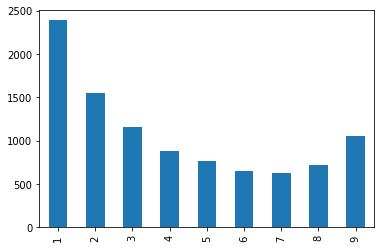

In [48]:
# We first need to get all the possible pairs user_id x twoweek
# And then aggregate at the user id level
nb_twoweeks_user=data[['user_id','twoweek']].drop_duplicates()
nb_twoweeks_user=pd.DataFrame(nb_twoweeks_user.groupby(['user_id']).size())
nb_twoweeks_user=nb_twoweeks_user.rename(columns={0:'nb_twoweek'})
nb_twoweeks_user.nb_twoweek.value_counts().sort_index().plot(kind='bar')

For most of the users we don't observe content consumption for all the time scope. It can be due to churn (users don't come back) or because they are new users (we don't observe the first weeks then).

#### User retention on a two-weeks basis

In [49]:
# We want to get the number of users that come back from one two-week period to another
# We first create a table of 0 and 1s
# if a given user (row) consume content on a given two-week (column)
twoweeks_user=data[['user_id','twoweek']].drop_duplicates().set_index('user_id')
twoweeks_user.twoweek=twoweeks_user.twoweek.apply(lambda x:str(x))
twoweeks_user=pd.get_dummies(twoweeks_user).reset_index().groupby(['user_id']).sum()
twoweeks_user.head()

,twoweek_0,twoweek_1,twoweek_2,twoweek_3,twoweek_4,twoweek_5,twoweek_6,twoweek_7,twoweek_8
user_id,,,,,,,,,
0001c6,0,1,0,0,0,0,1,0,1
000c1a,0,1,1,1,1,1,1,1,1
001c53,0,1,0,0,0,1,0,0,1
001d44,1,0,0,0,1,0,0,1,1
002b2e,1,1,0,0,0,0,0,0,0


In [50]:
# Let's build a retention matrix
ret_matrix=pd.DataFrame(columns=np.arange(0,9), index=np.arange(0,9))

for i in np.arange(0,8):
    # Number of user consuming content in a twoweek i in position i,i
    ret_matrix.loc[i,i]=sum(twoweeks_user['twoweek_'+str(i)])
    twoweeks_user.cumul_tmp=twoweeks_user['twoweek_'+str(i)]
    
    for j in np.arange(i+1,9):
        # Then we fill for the other columns of row i the number of users consuming
        # content in the followings twoweeks until j (without gaps)
        twoweeks_user.cumul_tmp+=twoweeks_user['twoweek_'+str(j)]
        ret_matrix.loc[i,j]=len(twoweeks_user[twoweeks_user.cumul_tmp==j+1-i])
        
ret_matrix.loc[8,8]=sum(twoweeks_user['twoweek_'+str(8)])
ret_matrix

,0,1,2,3,4,5,6,7,8
0,4377,2874,2159,1826,1559,1408,1264,1137,1049
1,NaN,6706,3633,2768,2231,1928,1672,1474,1353
2,NaN,NaN,5485,3467,2631,2199,1865,1614,1467
3,NaN,NaN,NaN,4375,3060,2478,2051,1740,1562
4,NaN,NaN,NaN,NaN,4001,2924,2306,1893,1681
5,NaN,NaN,NaN,NaN,NaN,4007,2796,2164,1874
6,NaN,NaN,NaN,NaN,NaN,NaN,3701,2524,2103
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3416,2547
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3755


In [51]:
# Let's put these results in ratios of the size of the cohorts
ret_matrix_ratio=pd.DataFrame(columns=np.arange(0,9), index=np.arange(0,9))
for i in np.arange(0,9):
    for j in np.arange(0,9):
        ret_matrix_ratio.loc[i,j]=ret_matrix.loc[i,j]/ret_matrix.loc[i,i]
ret_matrix_ratio

,0,1,2,3,4,5,6,7,8
0,1,0.656614,0.49326,0.417181,0.35618,0.321682,0.288782,0.259767,0.239662
1,NaN,1,0.541754,0.412765,0.332687,0.287504,0.249329,0.219803,0.20176
2,NaN,NaN,1,0.632088,0.479672,0.400912,0.340018,0.294257,0.267457
3,NaN,NaN,NaN,1,0.699429,0.5664,0.4688,0.397714,0.357029
4,NaN,NaN,NaN,NaN,1,0.730817,0.576356,0.473132,0.420145
5,NaN,NaN,NaN,NaN,NaN,1,0.697779,0.540055,0.467682
6,NaN,NaN,NaN,NaN,NaN,NaN,1,0.681978,0.568225
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.745609
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


__How to read this matrix?__

From all the users who consumed content in `twoweek` 0, more than 65% came back in `twoweek` 1 and around 50% are still consuming content on `twoweek` 2.

Among the users who consumed content on `twoweek` 4, 73% came back the `twoweek` after. Note that for this cohort, users might have consumed content before `twoweek` 4.

Only 24% of the users are consuming content during all the scope, with this time basis. Note that this is also what we found looking at the number of two-weeks timeframe a user consumes content above. 

If we want to get an average retention from one `twoweek` to another and not get into that much details, we can average the retention ratio observed for each `twoweek` the `twoweek` after.

In [52]:
# Let's compute an average retention ratio
ret_tw=[]
for i in np.arange(0,8):
    ret_tw+=[ret_matrix_ratio.loc[i,i+1]]
print('Average retention from one twoweek to another: '+str(np.mean(ret_tw)))

Average retention from one twoweek to another: 0.673258347659


The retention is quite high in this user database.


# Conclusion
## Save our new dataset
Finally we will save the data we have been working with in order to read it back in for the next lesson.

In [53]:
data.to_csv('iplayer_data_c1.csv', index=False)

## Summary of course 1

In this tutorial we have walked through some of the early steps involved in many data science problems: 
1. Formulating our problem;
2. Selecting the data we need to solve it;
3. Preparing and cleaning our data to make it easier to analyse
4. Exploring and making sense of our data,

In the next tutorial we will prepare the dataset that will feed in the the modelling part.